In [1]:
import pandas as pd
from os.path import join, isdir

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from icecream import ic
from src.utils import variant_utils as vu
from glob import glob
from itertools import product
from collections import defaultdict
from tqdm.notebook import tqdm
import pickle

from mplh.color_utils import create_color_df_v02

In [2]:
indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/mt_clones_thresh"
outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/mt_clones_thresh/dendro/"

N_DONORS=2

## Parameters:
# af thresholds
# coverage threshold
# other_af thresholds
# number of cells / fraction cells
# number of other cells / fraction other cells
af_t = 0.4
oth_af_t = 0.1
cov_t = 10
oth_cov_t = 10
ncells = 5
oth_ncells = 0.6
mean_pos_cov = 0

min_cell = 10

In [3]:
cells_dir=join(indir, "cells")

In [4]:
#samples = samples.split(",")

### Smaller params

In [5]:
def fill_mt_bin(curr_pos, curr_cells):
    print(curr_pos.name)
    curr_pos.loc[curr_cells[curr_pos.name]["other_cells"]] = 0
    curr_pos.loc[curr_cells[curr_pos.name]["clone_cells"]] = 1
    return curr_pos

In [6]:
bin_d = {}
for d in range(N_DONORS): 
    curr_f = join(cells_dir, f"don.{d}_af.{af_t}_othaf.{oth_af_t}_cov.{cov_t}_othcov.{oth_cov_t}.p")
    curr_cells = pickle.load(open(curr_f,'rb'))
    params_results = pd.read_csv(join(indir, f"donor_{d}_thresh_results.tsv"), sep="\t")    

    curr_p = params_results.loc[(params_results["af"]==af_t) &
                       (params_results["oth_af"]==oth_af_t) &
                       (params_results["cov"]==cov_t) &
                       (params_results["oth_cov"]==oth_cov_t) &
                       (params_results["ncells"]==ncells) &
                       (params_results["oth_ncells"]==oth_ncells) &
                       (params_results["mean_cov"]==mean_pos_cov)]
    assert(len(curr_p)==1)
    
    ## Construct a binary cell-by-variant matrix for the kept variants. 
    ## Can add N/A if not in oth cells
    curr_vars = curr_p.iloc[0]["Variants"].split(";")

    all_cells = set()
    for x in curr_cells:
        all_cells = all_cells.union(set(curr_cells[x]["clone_cells"])) 
        all_cells = all_cells.union(set(curr_cells[x]["other_cells"])) 

    mt_bin = pd.DataFrame(index = all_cells, columns=curr_vars)
    bin_d[d] = mt_bin.apply(fill_mt_bin, curr_cells=curr_cells,axis=0)


11453A
14674C
152C
16129A
1949A
2623G
3244A
8697A
8743A
10589A
11761T
146C
15297C
15497A
16129A
196C
204C
2442C
2623G
3244A
3847C
5442C
64T
827G
8292A


### Remove cells with all 0s and vars with less than min_cell number of cells

In [8]:
for d in bin_d:
    print(d)
    print(bin_d[d].shape)
    bin_d[d] = bin_d[d].loc[~((bin_d[d])==0).all(axis=1),~(bin_d[d].sum(axis=0)<min_cell)]
    print(bin_d[d].shape)

0
(8950, 9)
(3866, 9)
1
(8262, 16)
(3881, 16)


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


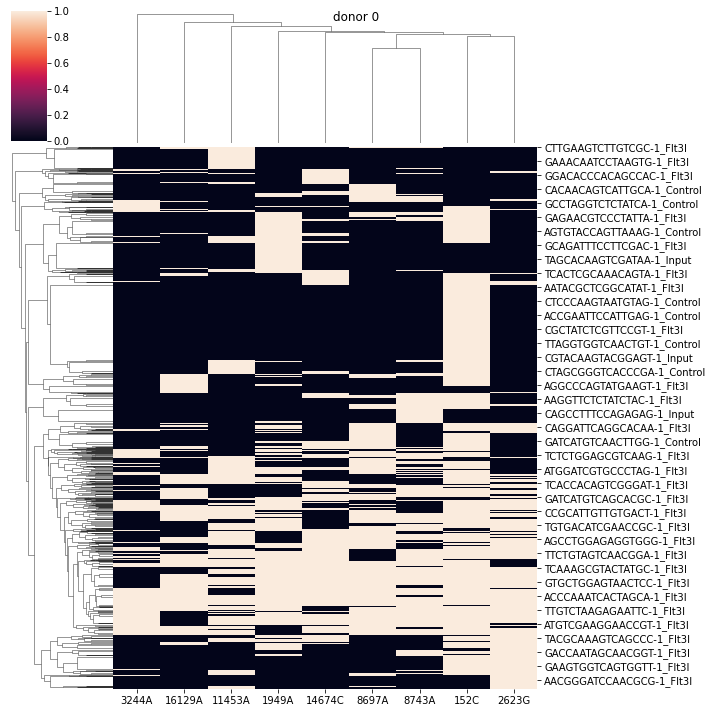

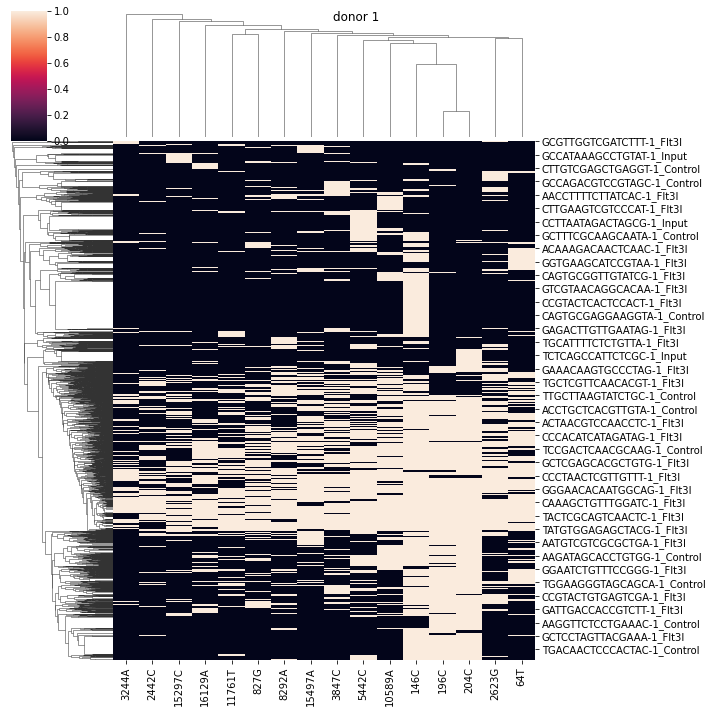

In [9]:
for d in bin_d:
    g = sns.clustermap(bin_d[d].astype(bool),metric='jaccard')
    g.fig.suptitle(f"donor {d}")
    plt.savefig(join(outdir, f"don_{d}_dendro_mt_as_clones.png"))